In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_auc_score, f1_score

In [2]:
df = pd.read_json("../reports/ae_test.jsonl", orient='records', lines=True)

In [3]:
df['anom_scores'] = df['anom_scores'].apply(np.array)
df['is_anom'] = df['is_anom'].apply(np.array)
df['roc_auc'] = df.apply(lambda row: roc_auc_score(row['is_anom'], row['anom_scores']), axis=1)

In [4]:
dfm = df.groupby(['dataset', 'lr_online', 'online_finetuning', 'p_anomaly'])['roc_auc'].mean()

In [6]:
df['mean_anom_score'] = df['anom_scores'].apply(np.mean)

In [7]:
df.groupby(['dataset', 'lr_online', 'online_finetuning', 'p_anomaly'])['mean_anom_score'].mean()

dataset         lr_online  online_finetuning  p_anomaly
Covertype       0.03125    True               0.02         0.020205
                                              0.04         0.020644
                                              0.08         0.021476
                0.06250    True               0.02         0.019843
                                              0.04         0.020283
                                              0.08         0.021108
                0.12500    True               0.02         0.019725
                                              0.04         0.020130
                                              0.08         0.020984
                0.25000    True               0.02         0.019945
                                              0.04         0.019139
                                              0.08         0.021355
                0.50000    False              0.04         0.034784
                           True               0.02         0

In [5]:
dfm

dataset         lr_online  online_finetuning  p_anomaly
Covertype       0.03125    True               0.02         0.993844
                                              0.04         0.993305
                                              0.08         0.992707
                0.06250    True               0.02         0.994284
                                              0.04         0.993746
                                              0.08         0.993195
                0.12500    True               0.02         0.994600
                                              0.04         0.992360
                                              0.08         0.993593
                0.25000    True               0.02         0.995090
                                              0.04         0.993064
                                              0.08         0.994075
                0.50000    False              0.04         0.987247
                           True               0.02         0

In [13]:
dfr = dfm.reset_index()
dfr = dfr[dfr['online_finetuning']]
idcs_best_lr = dfr.groupby(['dataset','p_anomaly'])['roc_auc'].idxmax()
dfr.loc[idcs_best_lr]

,dataset,lr_online,online_finetuning,p_anomaly,roc_auc
16,Covertype,1.000,True,0.02,0.996586
17,Covertype,1.000,True,0.04,0.995847
15,Covertype,0.500,True,0.08,0.994455
35,Insects abrupt,1.000,True,0.02,0.654307
36,Insects abrupt,1.000,True,0.04,0.654324
37,Insects abrupt,1.000,True,0.08,0.649269
54,Rotated MNIST,1.000,True,0.02,0.575266
55,Rotated MNIST,1.000,True,0.04,0.551073
46,Rotated MNIST,0.125,True,0.08,0.521342


In [71]:
def tumbling_roc_auc_score(row, window_size=1000):
    is_anom = row["is_anom"]
    anom_score = row["anom_scores"]
    return [
        roc_auc_score(
            is_anom[start : start + window_size],
            anom_score[start : start + window_size],
        )
        for start in range(0, len(anom_score) - window_size, window_size)
    ]


def tumbling_rec_error(row, window_size=1000):
    anom_score = row["anom_scores"]
    return [
        anom_score[start : start + window_size].mean()
        for start in range(0, len(anom_score) - window_size, window_size)
    ]


In [75]:
df4 = df[
    (df["p_anomaly"] == 0.04)
    & ((df["lr_online"] == 1.0) | (df["online_finetuning"] == False))
]
df4["tumbling_roc_auc"] = df4.apply(tumbling_roc_auc_score, axis=1)
df4["tumbling_rec_error"] = df4.apply(tumbling_rec_error, axis=1)

/tmp/ipykernel_5144/3972882609.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df4["tumbling_roc_auc"] = df4.apply(tumbling_roc_auc_score, axis=1)
/tmp/ipykernel_5144/3972882609.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df4["tumbling_rec_error"] = df4.apply(tumbling_rec_error, axis=1)


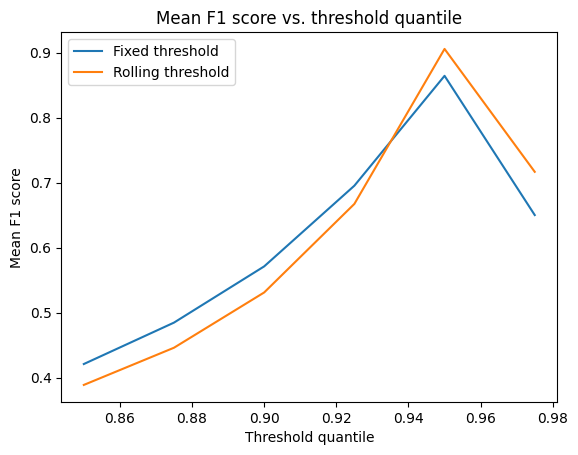

In [180]:
dataset = "Covertype"
df_online = df4[(df4["dataset"] == dataset) & (df4["online_finetuning"])]
df_offline = df4[(df4["dataset"] == dataset) & (~df4["online_finetuning"])]
quantiles = [0.85, 0.875, 0.9, 0.925, 0.95, 0.975]
f1_fixed = []
f1_rolling = []

for q in quantiles:
    f1s_fixed = []
    f1s_rolling = []
    for _, dfi in df_online.iterrows():
        anom_scores = np.array(dfi["anom_scores"])
        is_anom = np.array(dfi["is_anom"])
        # Fixed threshold
        fixed_thresh = np.quantile(anom_scores, q)
        preds_fixed = anom_scores > fixed_thresh
        f1s_fixed.append(f1_score(is_anom, preds_fixed))
        # Rolling threshold
        rolling_mean = pd.Series(anom_scores).rolling(1000, min_periods=1).mean().values

        preds_rolling = (anom_scores / rolling_mean) > fixed_thresh / anom_scores.mean()
        f1s_rolling.append(f1_score(is_anom, preds_rolling))
    f1_fixed.append(np.mean(f1s_fixed))
    f1_rolling.append(np.mean(f1s_rolling))

plt.plot(quantiles, f1_fixed, label="Fixed threshold")
plt.plot(quantiles, f1_rolling, label="Rolling threshold")
plt.xlabel("Threshold quantile")
plt.ylabel("Mean F1 score")
plt.legend()
plt.title("Mean F1 score vs. threshold quantile")
plt.show()



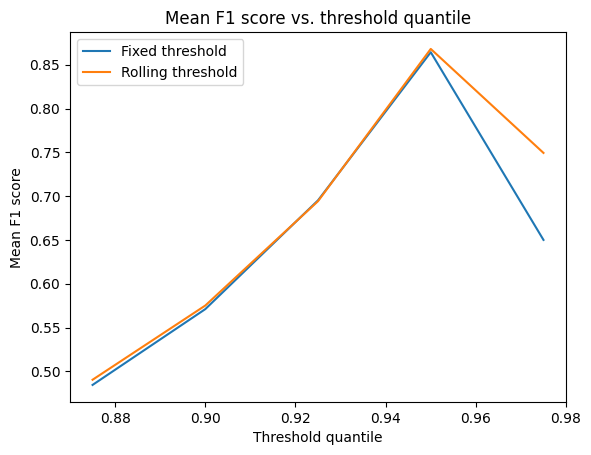

In [ ]:
dataset = 'Covertype'
df_online = df4[(df4["dataset"] == dataset) & (df4["online_finetuning"])]
df_offline = df4[(df4["dataset"] == dataset) & (~df4["online_finetuning"])]
quantiles = [
.875, 0.9, 0.925, 0.95, 0.975
]
f1_fixed = []
f1_rolling = []

for q in quantiles:
    f1s_fixed = []
    f1s_rolling = []
    for _, dfi in df_online.iterrows():
        anom_scores = np.array(dfi["anom_scores"])
        is_anom = np.array(dfi["is_anom"])
        # Fixed threshold
        fixed_thresh = np.quantile(anom_scores, q)
        preds_fixed = anom_scores > fixed_thresh
        f1s_fixed.append(f1_score(is_anom, preds_fixed))
        # Rolling threshold
        rolling_thresh = pd.Series(anom_scores).rolling(2000, min_periods=1).quantile(q).values
        preds_rolling = anom_scores > rolling_thresh
        f1s_rolling.append(f1_score(is_anom, preds_rolling))
    f1_fixed.append(np.mean(f1s_fixed))
    f1_rolling.append(np.mean(f1s_rolling))

plt.plot(quantiles, f1_fixed, label="Fixed threshold")
plt.plot(quantiles, f1_rolling, label="Rolling threshold")
plt.xlabel("Threshold quantile")
plt.ylabel("Mean F1 score")
plt.legend()
plt.title("Mean F1 score vs. threshold quantile")
plt.show()


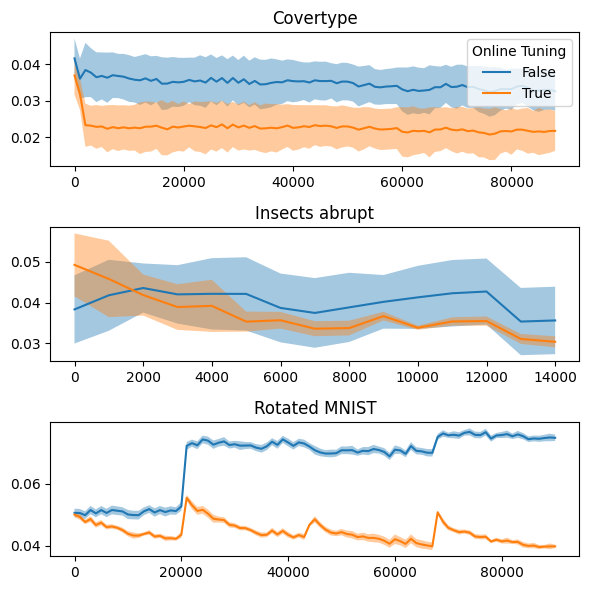

In [76]:
# Plot reconstruction error vs. time
fig, axs = plt.subplots(nrows=3, figsize=(6, 6))
y_metric = 'tumbling_rec_error'

for ax, (dataset, dfg) in zip(axs, df4.groupby(["dataset"])):
    for online, dfo in dfg.groupby("online_finetuning"):
        roc_scores = dfo[y_metric].to_list()
        min_len = min([len(roc_score) for roc_score in roc_scores])
        score_array = np.array([score[:min_len] for score in roc_scores])
        mean_scores = score_array.mean(axis=0)
        std_scores = score_array.std(axis=0)
        x = np.arange(0, len(mean_scores)) * 1000
        ax.plot(x, mean_scores, label=online)
        ax.fill_between(x, mean_scores-std_scores, mean_scores+std_scores, alpha=.4)
        ax.set_title(dataset[0])
        


axs[0].legend(title='Online Tuning')
fig.tight_layout()

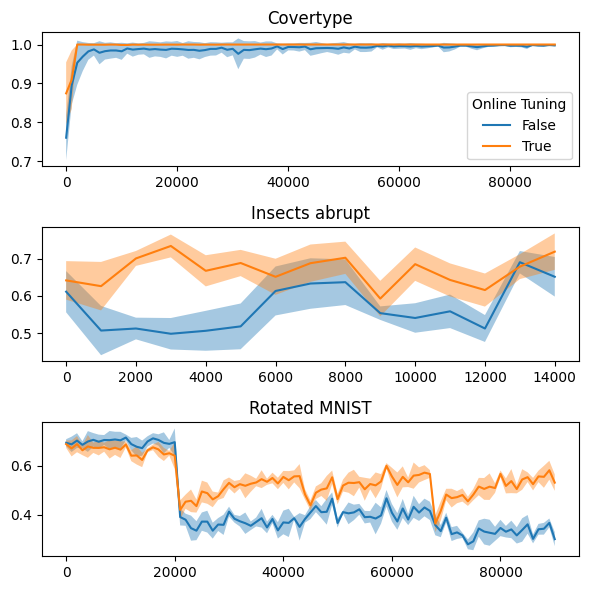

In [ ]:
# Plot ROC AUC scores vs. time
fig, axs = plt.subplots(nrows=3, figsize=(6, 6))

for ax, (dataset, dfg) in zip(axs, df4.groupby(["dataset"])):
    for online, dfo in dfg.groupby("online_finetuning"):
        roc_scores = dfo["tumbling_roc_auc"].to_list()
        min_len = min([len(roc_score) for roc_score in roc_scores])
        score_array = np.array([score[:min_len] for score in roc_scores])
        mean_scores = score_array.mean(axis=0)
        std_scores = score_array.std(axis=0)
        x = np.arange(0, len(mean_scores)) * 1000
        ax.plot(x, mean_scores, label=online)
        ax.fill_between(x, mean_scores-std_scores, mean_scores+std_scores, alpha=.4)
        ax.set_title(dataset[0])
        
axs[0].legend(title='Online Tuning')
fig.tight_layout()